In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ticker = yf.Ticker("AAPL")
history = ticker.history(period="max")
latest_date = history.tail(1).index[0]
s_date = input("Enter the period in '%Y-%m-%d' format")

In [3]:
BTC_USD = yf.download("BTC-USD", start= s_date, end= latest_date, interval='1d')
BTC_USD.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-01,43194.503906,44793.601562,42952.585938,44354.636719,44354.636719,32479047645
2022-03-02,44357.617188,45077.578125,43432.851562,43924.117188,43924.117188,29183112630
2022-03-03,43925.195312,44021.578125,41914.750000,42451.789062,42451.789062,24967782593
2022-03-04,42458.140625,42479.613281,38805.847656,39137.605469,39137.605469,28516271427
2022-03-05,39148.449219,39566.335938,38777.035156,39400.585938,39400.585938,16975917450


# 1. Computing the Simple Moving Averages

In [4]:
BTC_USD['SMA_30'] = BTC_USD['Close'].rolling(window=100, min_periods=1).mean()
BTC_USD['SMA_300'] = BTC_USD['Close'].rolling(window = 300, min_periods = 1).mean()
BTC_USD.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_30,SMA_300
Date,,,,,,,,
2022-03-01,43194.503906,44793.601562,42952.585938,44354.636719,44354.636719,32479047645,44354.636719,44354.636719
2022-03-02,44357.617188,45077.578125,43432.851562,43924.117188,43924.117188,29183112630,44139.376953,44139.376953
2022-03-03,43925.195312,44021.578125,41914.750000,42451.789062,42451.789062,24967782593,43576.847656,43576.847656
2022-03-04,42458.140625,42479.613281,38805.847656,39137.605469,39137.605469,28516271427,42467.037109,42467.037109
2022-03-05,39148.449219,39566.335938,38777.035156,39400.585938,39400.585938,16975917450,41853.746875,41853.746875


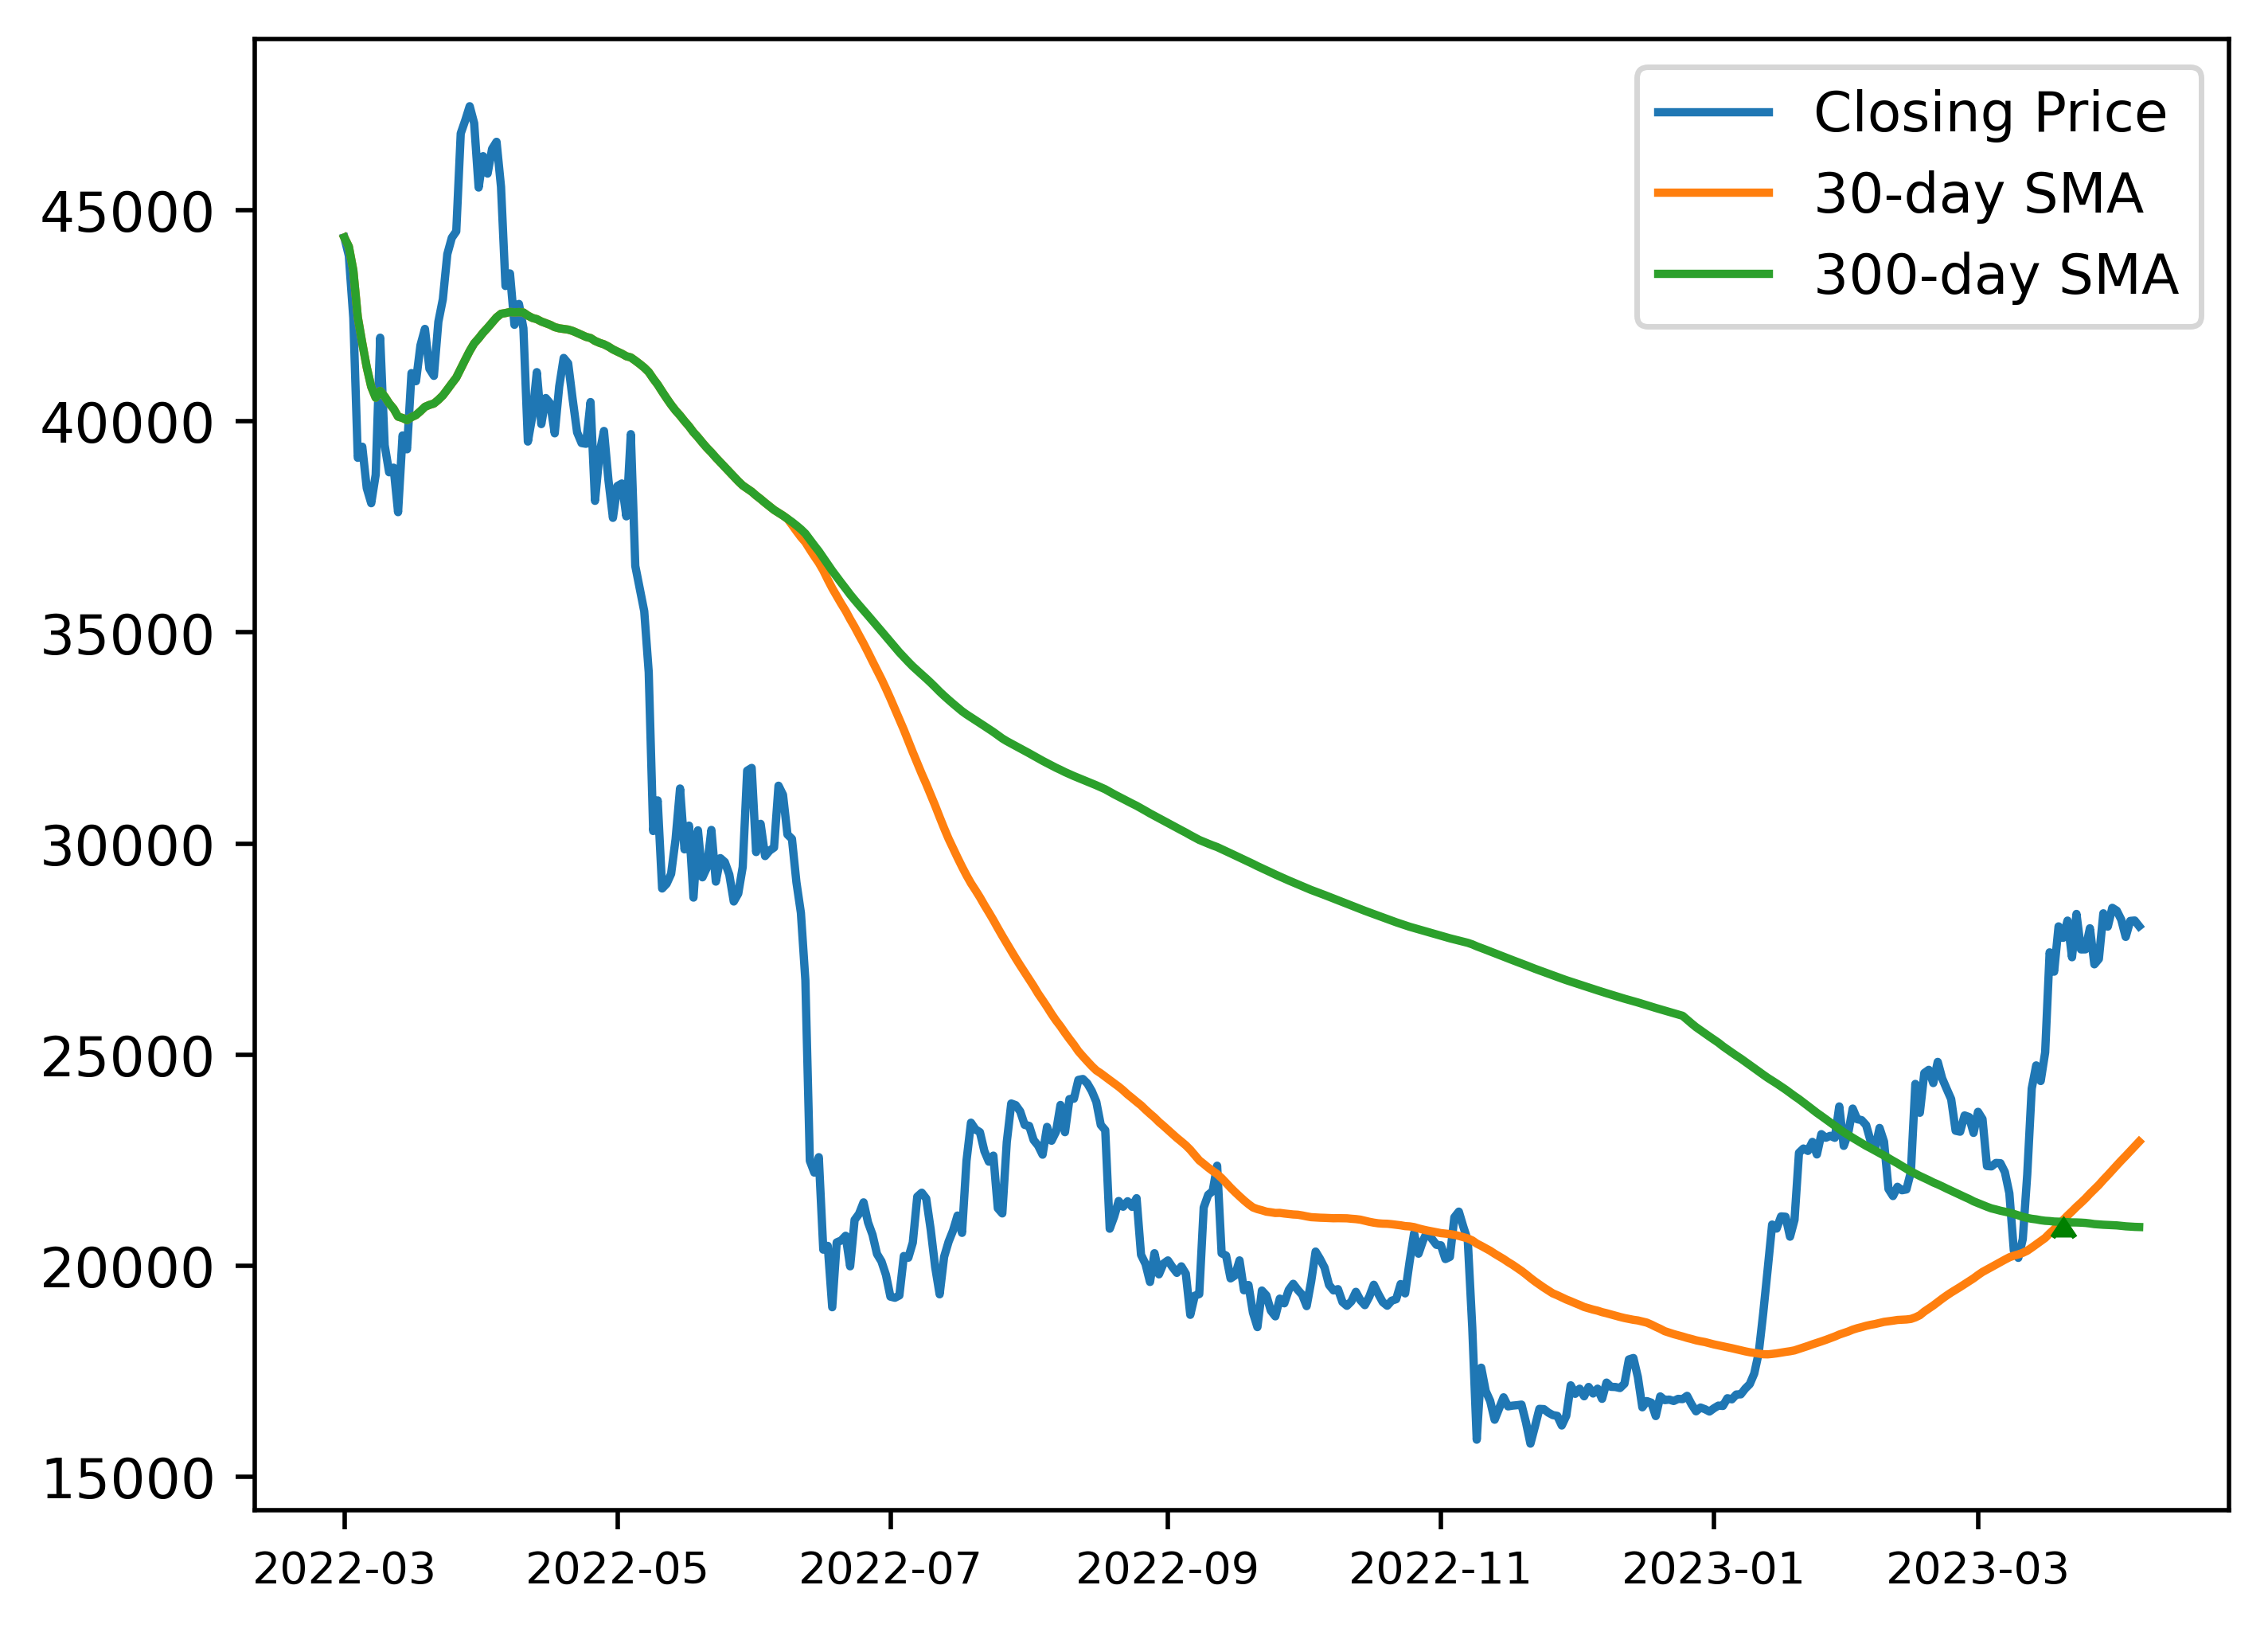

In [5]:
BTC_USD['Signal'] = 0.0
BTC_USD['Signal'] = np.where(BTC_USD['SMA_30'] > BTC_USD['SMA_300'], 1.0, 0.0)   
BTC_USD['Position'] = BTC_USD['Signal'].diff()


fig, ax = plt.subplots(dpi=500)
ax.tick_params(axis='x', labelsize=8)

ax.plot(BTC_USD.index, BTC_USD['Close'], label='Closing Price')
ax.plot(BTC_USD['SMA_30'].index, BTC_USD['SMA_30'] , label='30-day SMA')
ax.plot(BTC_USD['SMA_300'].index, BTC_USD['SMA_300'] , label='300-day SMA')

ax.plot(BTC_USD.loc[BTC_USD['Position']==1.0].index, BTC_USD.SMA_30[BTC_USD['Position'] == 1.0],marker=6, ms=4, linestyle='none', color='green')

 # Adding red arrows to indicate sell orders
ax.plot(BTC_USD.loc[BTC_USD['Position'] == -1.0].index, BTC_USD.SMA_30[BTC_USD['Position'] == -1.0],
 marker=7, ms=4, linestyle='none', color='red')

ax.legend()
plt.show()

# 2. Computing the Relative Strength Index (RSI)

In [7]:
# Calculate the price change and gain/loss for each day
BTC_USD['PriceChange'] = BTC_USD['Close'] - BTC_USD['Close'].shift(1)
BTC_USD['Gain'] = BTC_USD['PriceChange'].where(BTC_USD['PriceChange'] > 0, 0)
BTC_USD['Loss'] = -BTC_USD['PriceChange'].where(BTC_USD['PriceChange'] < 0, 0)

# Calculate the smoothed average gain and loss
window = 14  # RSI period
BTC_USD['AvgGain'] = BTC_USD['Gain'].rolling(window=window).mean()
BTC_USD['AvgLoss'] = BTC_USD['Loss'].rolling(window=window).mean()

# Calculate the relative strength (RS)
BTC_USD['RS'] = BTC_USD['AvgGain'] / BTC_USD['AvgLoss']

# Calculate the RSI
BTC_USD['RSI'] = 100 - (100 / (1 + BTC_USD['RS']))

# Drop unnecessary columns
BTC_USD = BTC_USD.drop(['PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS'], axis=1)

# Print the DataFrame with RSI values
print(BTC_USD.tail())

                    Open          High           Low         Close  \
Date                                                                 
2023-04-02  28462.845703  28518.958984  27884.087891  28199.308594   
2023-04-03  28183.080078  28475.623047  27276.720703  27790.220703   
2023-04-04  27795.273438  28433.742188  27681.304688  28168.089844   
2023-04-05  28169.726562  28739.238281  27843.763672  28177.984375   
2023-04-06  28175.226562  28178.384766  27738.759766  28044.140625   

               Adj Close       Volume        SMA_30       SMA_300  Signal  \
Date                                                                        
2023-04-02  28199.308594  12284641999  22492.053281  20946.020228     1.0   
2023-04-03  27790.220703  19556501327  22601.477930  20934.802702     1.0   
2023-04-04  28168.089844  15284538859  22714.738965  20927.981816     1.0   
2023-04-05  28177.984375  17052315986  22827.320762  20921.535104     1.0   
2023-04-06  28044.140625  13837809380  22940.59

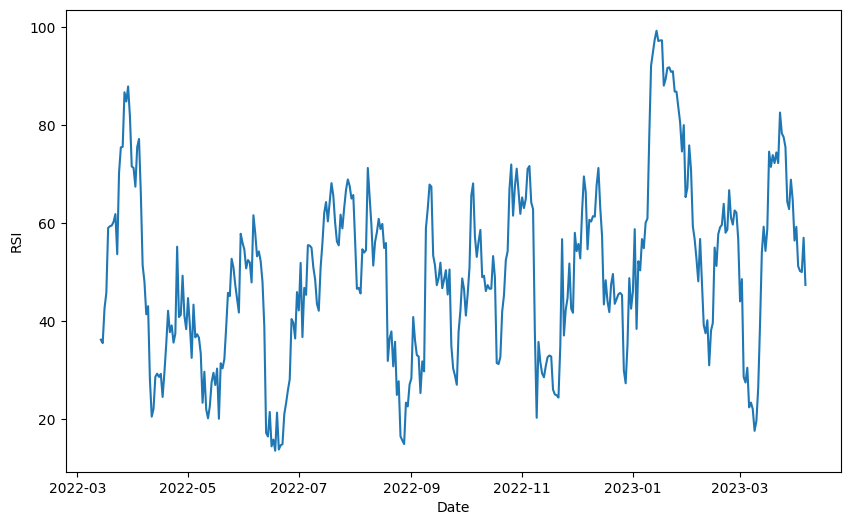

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(BTC_USD['RSI'])
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()